In [1]:
import h5py
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import concurrent.futures
from scipy.optimize import curve_fit
from scipy.special import factorial
from matplotlib.colors import LogNorm


plot_dir = os.path.join("/net/nfshome/home/sfischer/BA/presentation/plots")
os.makedirs(plot_dir, exist_ok=True)

In [2]:
pathlist = sorted(glob.glob('/cephfs/users/lwitthaus/coincidence_analysis/*.hdf5'))

excluded_indices = [8, 23, 24, 33, 35, 36, 38, 41, 47, 51, 53, 55, 61, 68, 70, 74, 80]  # List of indices to exclude
filtered_pathlist = [path for i, path in enumerate(pathlist) if i not in excluded_indices]

In [3]:
df_list = []
for path in filtered_pathlist:
    df_temp = pd.read_hdf(path,'MMCTrackList')
    df_weights_temp = pd.read_hdf(path, 'weights')
    df_temp = df_temp.join(df_weights_temp[['Event', 'GaisserH3aWeight']], on='Event', lsuffix= 'x')
    df_list.append(df_temp)

df = pd.concat(df_list)
df['GaisserH3aWeight']= df['GaisserH3aWeight']/ len(filtered_pathlist)

In [4]:
energy = df.energy
zenith = df.zenith
speed = df.speed
length = df.length
Ei = df.Ei
Ef = df.Ef
Ec = df.Ec
Elost = df.Elost

In [5]:
tau5 = 5*10**(-6) # s
def R_co(R,tau=tau5):
    sum_k = sum(((R*tau)**k) / factorial(k) for k in range(1,100))
    result = R * np.exp(-R*tau) * sum_k
    return result

def P_co(R,tau=tau5):
    sum_k = sum(((R*tau)**k) / factorial(k) for k in range(1,100))
    result = np.exp(-R*tau) * sum_k
    return result


In [6]:
micro = 10**(-6)
tau_vals = [1*micro, 3*micro, 5*micro, 7*micro, 9*micro]

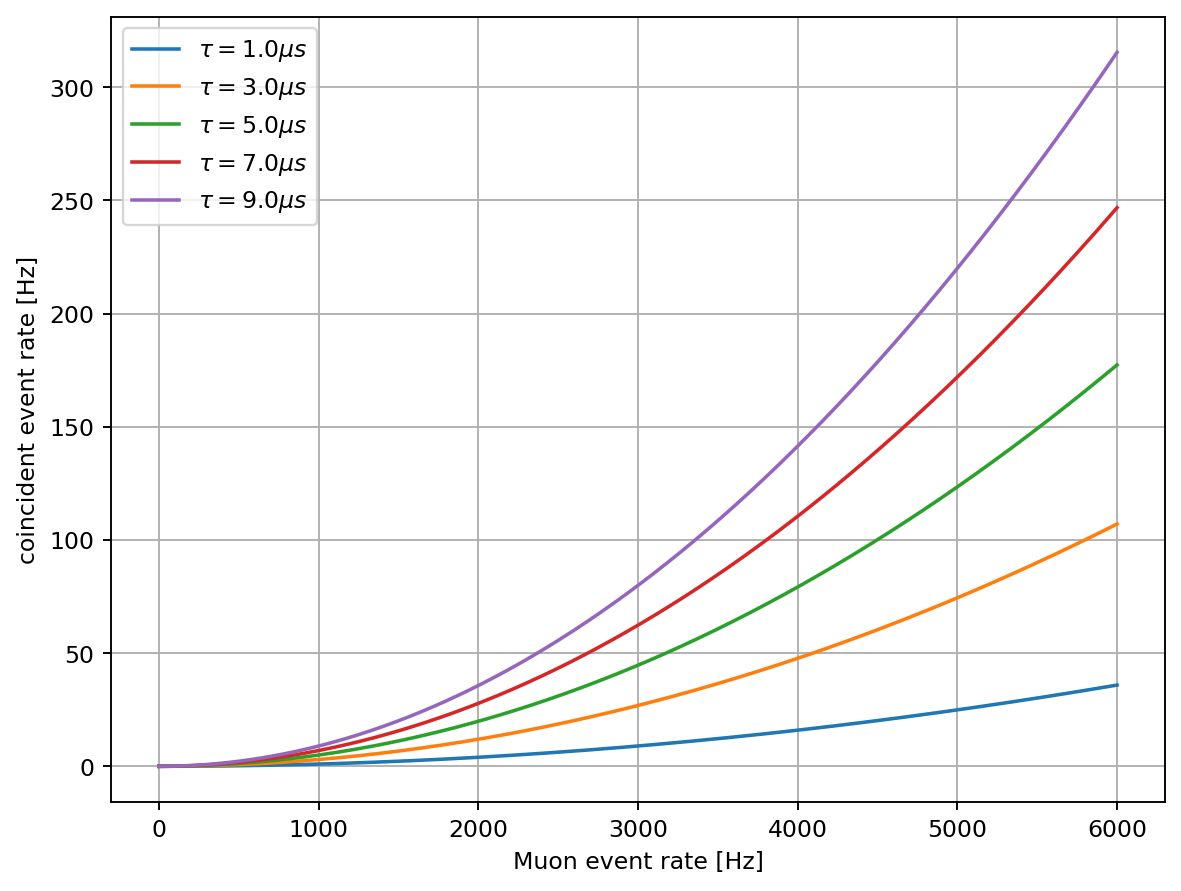

In [7]:
r_space = np.linspace(0,6000, 1000)
plt.figure(figsize=(8, 6), dpi=170)
for tau in tau_vals:
    plt.plot(r_space, R_co(r_space, tau), label=fr'$\tau =${tau*10**6:.1f}$\mu s$')
    plt.legend()
    plt.grid(True)
    plt.xlabel(f'Muon event rate [Hz]')
    plt.ylabel('coincident event rate [Hz]')
plt.savefig('coincidence_rate_poisson.pdf', format='pdf')

In [8]:
from matplotlib.colors import LogNorm
r_space_cut = np.linspace(200,6000, 1000)
# Update tau values to span from 1 microsecond to 10 milliseconds
tau_values = np.linspace(10**(-6), 10**(-5), 200)  # Logarithmic range from 1 µs to 10 ms

# Recompute R_co_matrix with the new tau values
R_co_matrix = np.zeros((len(tau_values), len(r_space_cut)))

for i, tau in enumerate(tau_values):
    for j, R in enumerate(r_space_cut):
        R_co_matrix[i, j] = R_co(R, tau)


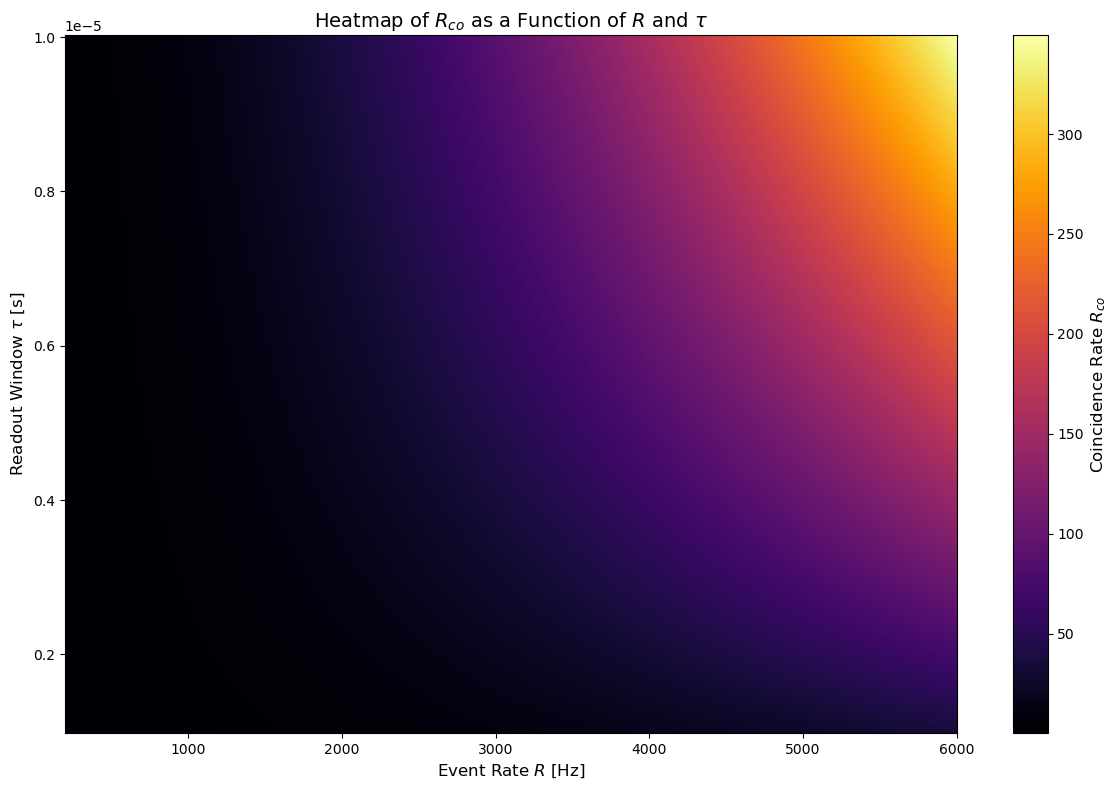

In [9]:
# Plot the heatmap with logarithmic color scale
plt.figure(figsize=(12, 8))
plt.pcolormesh(r_space_cut, tau_values, R_co_matrix, shading='auto', cmap='inferno', norm=plt.Normalize(vmin=np.min(R_co_matrix), vmax=np.max(R_co_matrix)))

# Add color bar
cbar = plt.colorbar()
cbar.set_label(r'Coincidence Rate $R_{co}$', fontsize=12)

# Set axis scales and labels
plt.xscale('linear')  # Linear scale for R
plt.yscale('linear')  # Logarithmic scale for tau
plt.xlabel(r'Event Rate $R$ [Hz]', fontsize=12)
plt.ylabel(r'Readout Window $\tau$ [s]', fontsize=12)
plt.title(r'Heatmap of $R_{co}$ as a Function of $R$ and $\tau$', fontsize=14)
plt.tight_layout()

# Save and display the updated plot
plt.savefig('heatmap_R_tau_Rco_logscale.png', format='png')
plt.show()

In [10]:
from matplotlib.colors import LogNorm
r_space_cut = np.linspace(200,6000, 50)
# Update tau values to span from 1 microsecond to 10 milliseconds
tau_values = np.linspace(10**(-6), 10**(-5), 50)  # Logarithmic range from 1 µs to 10 ms

# Recompute R_co_matrix with the new tau values
P_co_matrix = np.zeros((len(tau_values), len(r_space_cut)))

for i, tau in enumerate(tau_values):
    for j, R in enumerate(r_space_cut):
        P_co_matrix[i, j] = P_co(R, tau)

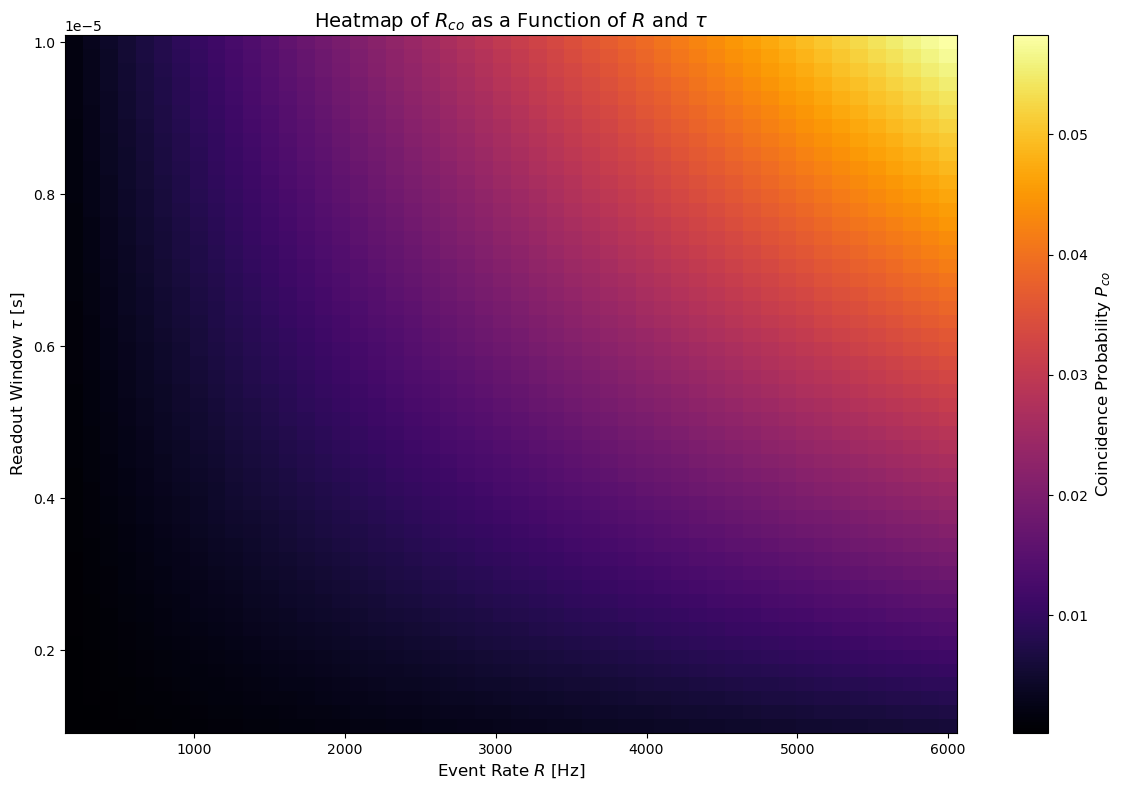

In [11]:
# Plot the heatmap with logarithmic color scale
plt.figure(figsize=(12, 8))
plt.pcolormesh(r_space_cut, tau_values, P_co_matrix, shading='auto', cmap='inferno', norm=plt.Normalize(vmin=np.min(P_co_matrix), vmax=np.max(P_co_matrix)))

# Add color bar
cbar = plt.colorbar()
cbar.set_label(r'Coincidence Probability $P_{co}$', fontsize=12)

# Set axis scales and labels
plt.xscale('linear')  # Linear scale for R
plt.yscale('linear')  # Logarithmic scale for tau
plt.xlabel(r'Event Rate $R$ [Hz]', fontsize=12)
plt.ylabel(r'Readout Window $\tau$ [s]', fontsize=12)
plt.title(r'Heatmap of $R_{co}$ as a Function of $R$ and $\tau$', fontsize=14)
plt.tight_layout()

# Save and display the updated plot
plt.savefig('heatmap_R_tau_Rco_logscale.png', format='png')
plt.show()

In [12]:
plt.figure(figsize=(8, 6), dpi=170)

df_grouped = df.groupby(['Run','Event'], as_index=False).agg({
    'Ei': 'sum',
    'Ec': 'sum',
    'Ef': 'sum',
    'Elost': 'sum',    
    'GaisserH3aWeight': 'first',
    'zenith': 'first',
    'azimuth': 'first',
    'speed': 'first', 
    'length': 'first'
})

<Figure size 1360x1020 with 0 Axes>

In [13]:
df_grouped[['GaisserH3aWeight']].sum(), df[['GaisserH3aWeight']].sum()
mask = df_grouped['Ei'].notna() & df_grouped['Ei'].notnull()

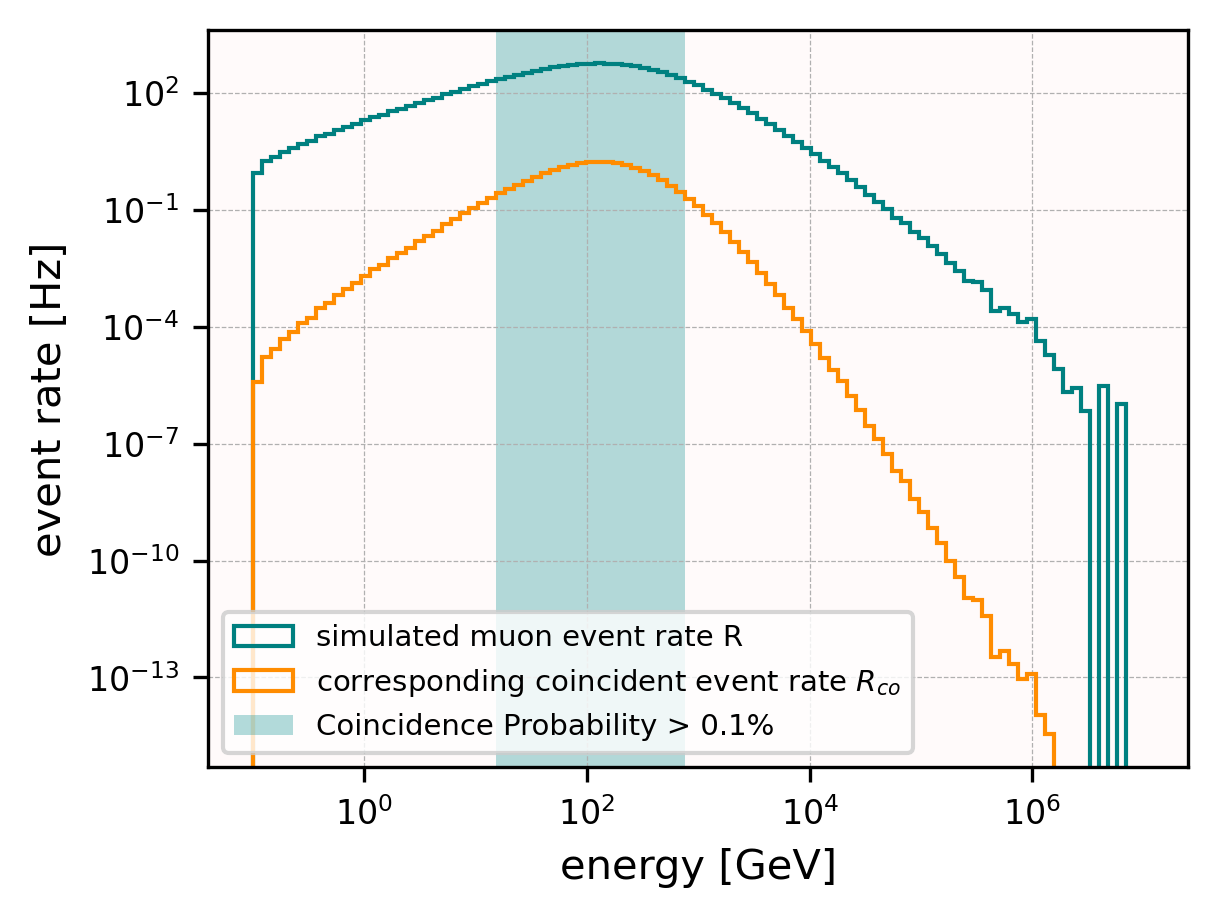

In [14]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

# Define the function for R_co
tau5 = 5 * 10**(-6)  # s
def R_co(R, tau=tau5):
    sum_k = sum(((R * tau) ** k) / factorial(k) for k in range(1, 100))
    result = R * np.exp(-R * tau) * sum_k
    return result

# Histogram 1 (Original)
bins_1 = np.logspace(-1, 7, 100)
plt.figure(figsize=(4, 3), dpi=300)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('energy [GeV]', fontsize=10)
plt.ylabel('event rate [Hz]', fontsize=10)
plt.grid(True, which='major', linestyle='--', linewidth=0.3)
plt.gca().set_facecolor('snow')

# First histogram
counts_1, bin_edges_1, patches_1 = plt.hist(
    df_grouped['Ei'][mask], 
    bins=bins_1, 
    histtype='step', 
    color='lightseagreen', 
    edgecolor='teal', 
    weights=df_grouped['GaisserH3aWeight'][mask],
    label= r'simulated muon event rate R'
)

# Calculate bin centers for original histogram
bin_centers_1 = (bin_edges_1[1:] + bin_edges_1[:-1]) / 2

# Compute R_co for each count
R_co_values = [R_co(R) for R in counts_1]

# Second histogram (Overlay)
plt.hist(
    bin_centers_1, 
    bins=bins_1, 
    weights=R_co_values,  # Use the computed R_co values
    histtype='step', 
    color='orange', 
    edgecolor='darkorange', 
    label=r'corresponding coincident event rate $R_{co}$'
)

# Add interval visualization
x = 0.001  # Percentage threshold (1 = 100%)
threshold = x * counts_1  # Calculate threshold

# Highlight bins where R_co exceeds the threshold
label_added = False  # Initialize a flag

for i, (R_co_val, count_val, bin_start, bin_end) in enumerate(zip(R_co_values, counts_1, bin_edges_1[:-1], bin_edges_1[1:])):
    if R_co_val > threshold[i]:  # Check if R_co exceeds threshold
        if not label_added:  # Add the label only for the first matching interval
            plt.axvspan(bin_start, bin_end, color='darkcyan', alpha=0.3, linewidth=0, label=r"Coincidence Probability > 0.1%")
            label_added = True
        else:
            plt.axvspan(bin_start, bin_end, color='darkcyan', alpha=0.3, linewidth=0)  # No label for subsequent intervals


# Add a legend to distinguish the histograms and intervals
plt.legend(fontsize=7, loc='lower left')
plt.tight_layout(pad=0.5)
plt.savefig('coincidence_rate_energy.pdf', format='pdf')
plt.show()


In [15]:
# Calculate the maximum percentage (R_co / R)
max_percentage = max(R_co_val / count_val if count_val > 0 else 0 for R_co_val, count_val in zip(R_co_values, counts_1))

# Find the edges of the highlighted area
highlighted_edges = [
    (bin_start, bin_end)
    for R_co_val, count_val, bin_start, bin_end in zip(R_co_values, counts_1, bin_edges_1[:-1], bin_edges_1[1:])
    if R_co_val > x * count_val
]

# Extract the lowest and highest energy values
if highlighted_edges:
    lowest_energy = highlighted_edges[0][0]
    highest_energy = highlighted_edges[-1][1]
else:
    lowest_energy = None
    highest_energy = None

# Print the results
print(f"Maximum percentage (R_co / R): {max_percentage:.5f}")
print(f"Lowest energy of highlighted area: {lowest_energy}")
print(f"Highest energy of highlighted area: {highest_energy}")


Maximum percentage (R_co / R): 0.00294
Lowest energy of highlighted area: 15.199110829529348
Highest energy of highlighted area: 756.463327554629


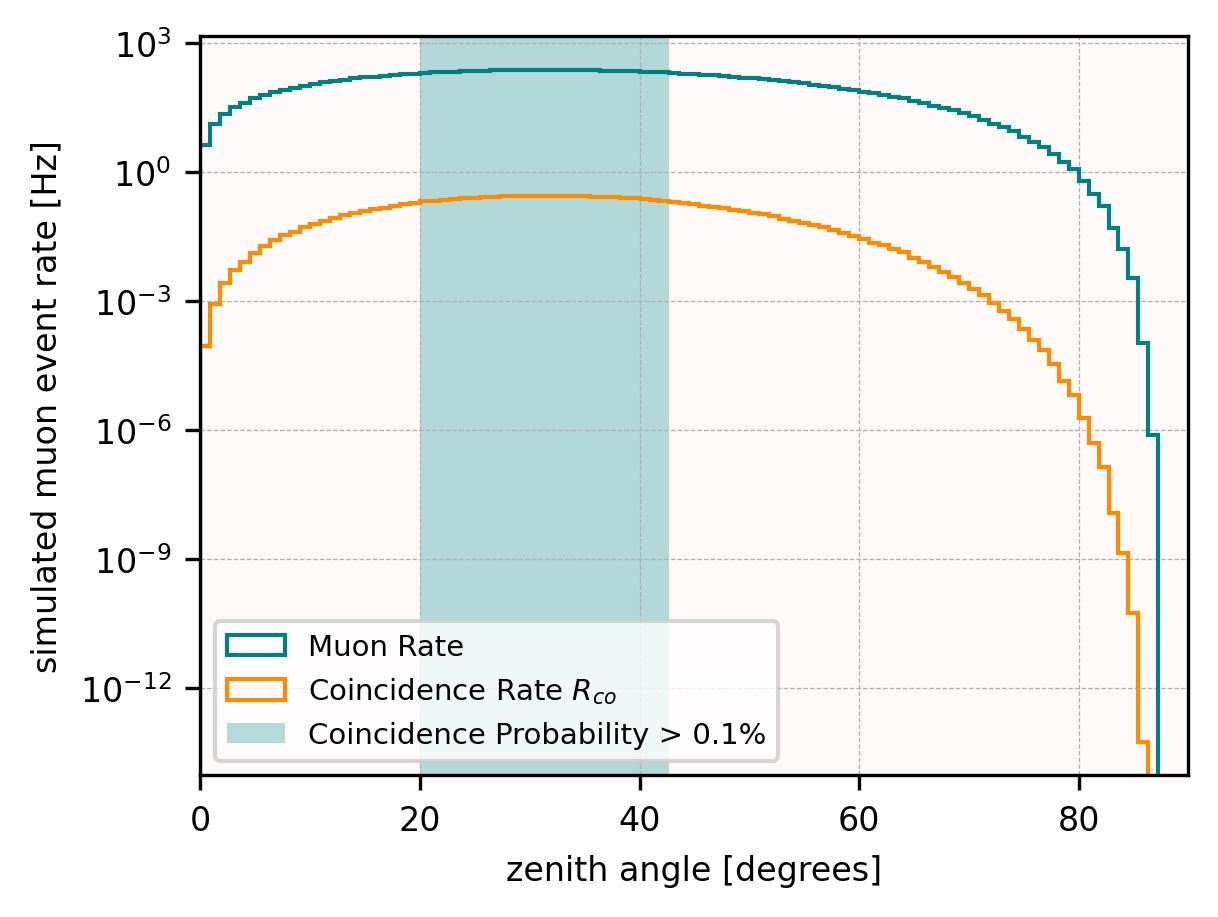

In [16]:
# Define bins for zenith angle (adjust as needed for appropriate resolution)
bins_zenith = np.linspace(0, np.pi/2, 100)  # Zenith angles typically range from 0 to π radians
# Define bins for zenith angle in degrees
bins_zenith_deg = np.linspace(0, 90, 100)  # Zenith angles in degrees (0° to 90°)

plt.figure(figsize=(4, 3), dpi=300)
plt.xscale('linear')  # Zenith angles are linear
plt.yscale('log')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('zenith angle [degrees]', fontsize=8)  # Updated label to degrees
plt.ylabel('simulated muon event rate [Hz]', fontsize=8)
plt.grid(True, which='major', linestyle='--', linewidth=0.3)
plt.gca().set_facecolor('snow')

# First histogram (Zenith without weights, converted to degrees)
counts_zenith, bin_edges_zenith, patches_zenith = plt.hist(
    np.degrees(df_grouped['zenith'][mask]),  # Convert zenith angles from radians to degrees
    bins=bins_zenith_deg, 
    histtype='step', 
    color='lightseagreen', 
    edgecolor='teal',
    weights=df_grouped['GaisserH3aWeight'][mask],
    label='Muon Rate'
)

# Calculate bin centers for the zenith histogram
bin_centers_zenith = (bin_edges_zenith[1:] + bin_edges_zenith[:-1]) / 2

# Compute R_co for each count in zenith histogram
R_co_zenith = [R_co(R) for R in counts_zenith]

# Overlay the second histogram for R_co(zenith)
plt.hist(
    bin_centers_zenith, 
    bins=bins_zenith_deg, 
    weights=R_co_zenith,  # Use computed R_co values
    histtype='step', 
    color='orange', 
    edgecolor='darkorange', 
    label=r'Coincidence Rate $R_{co}$'
)

# Add interval visualization for zenith
x_zenith = 0.001  # Percentage threshold (1 = 100%)
threshold_zenith = x_zenith * counts_zenith  # Calculate threshold

label_added = False 
# Highlight bins where R_co exceeds the threshold for zenith
for i, (R_co_val, count_val, bin_start, bin_end) in enumerate(zip(R_co_zenith, counts_zenith, bin_edges_zenith[:-1], bin_edges_zenith[1:])):
    if R_co_val > threshold_zenith[i]:  # Check if R_co exceeds threshold
        if not label_added:  # Add the label only for the first matching interval
            plt.axvspan(bin_start, bin_end, color='darkcyan', alpha=0.3, linewidth=0, label=r"Coincidence Probability > 0.1%")
            label_added = True
        else:
            plt.axvspan(bin_start, bin_end, color='darkcyan', alpha=0.3, linewidth=0)  # No label for subsequent intervals
# Add a legend to distinguish the histograms and intervals
plt.legend(fontsize=7, loc='lower left')
plt.tight_layout(pad=0.5)
plt.savefig('coincidence_rate_zenith_degrees.pdf', format='pdf')
plt.xlim(0, 90)  # Adjust x-axis limit to degrees
plt.show()




In [17]:
print(counts_zenith.sum())
print(counts_1.sum())

11217.70910008779
11217.709099641614


In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# # Calculate the percentage for each bin
# percentages = np.array([R_co_val / count_val if count_val > 0 else 0 for R_co_val, count_val in zip(R_co_values, counts_1)])

# # Set up the figure
# fig, ax = plt.subplots(figsize=(8, 8), dpi=170)

# # Define the color map (e.g., coolwarm, viridis, or your choice)
# cmap = plt.cm.viridis
# norm = mcolors.Normalize(vmin=0, vmax=0.01)  # Normalize to [0, 1] range

# # Plot the heatmap using bin edges and percentages
# for bin_start, bin_end, percentage in zip(bin_edges_1[:-1], bin_edges_1[1:], percentages):
#     color = cmap(norm(percentage))  # Map percentage to a color
#     ax.axvspan(bin_start, bin_end, color=color, alpha=0.8, linewidth=0 )

# # Add a color bar to indicate the percentage values
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.2)
# cbar.set_label("Percentage $R_{co}/R$", fontsize=10)

# # Set axis scale and labels
# ax.set_ylim(0,0.01)
# ax.set_xscale('log')  # Assuming energy or zenith is on a logarithmic scale
# ax.set_xlabel("Energy [GeV]", fontsize=10)
# ax.set_ylabel("Heatmap", fontsize=10)  # This is just illustrative; adjust as needed
# ax.set_title("Percentage Heatmap $R_{co}/R$", fontsize=12)

# plt.tight_layout()
# plt.show()


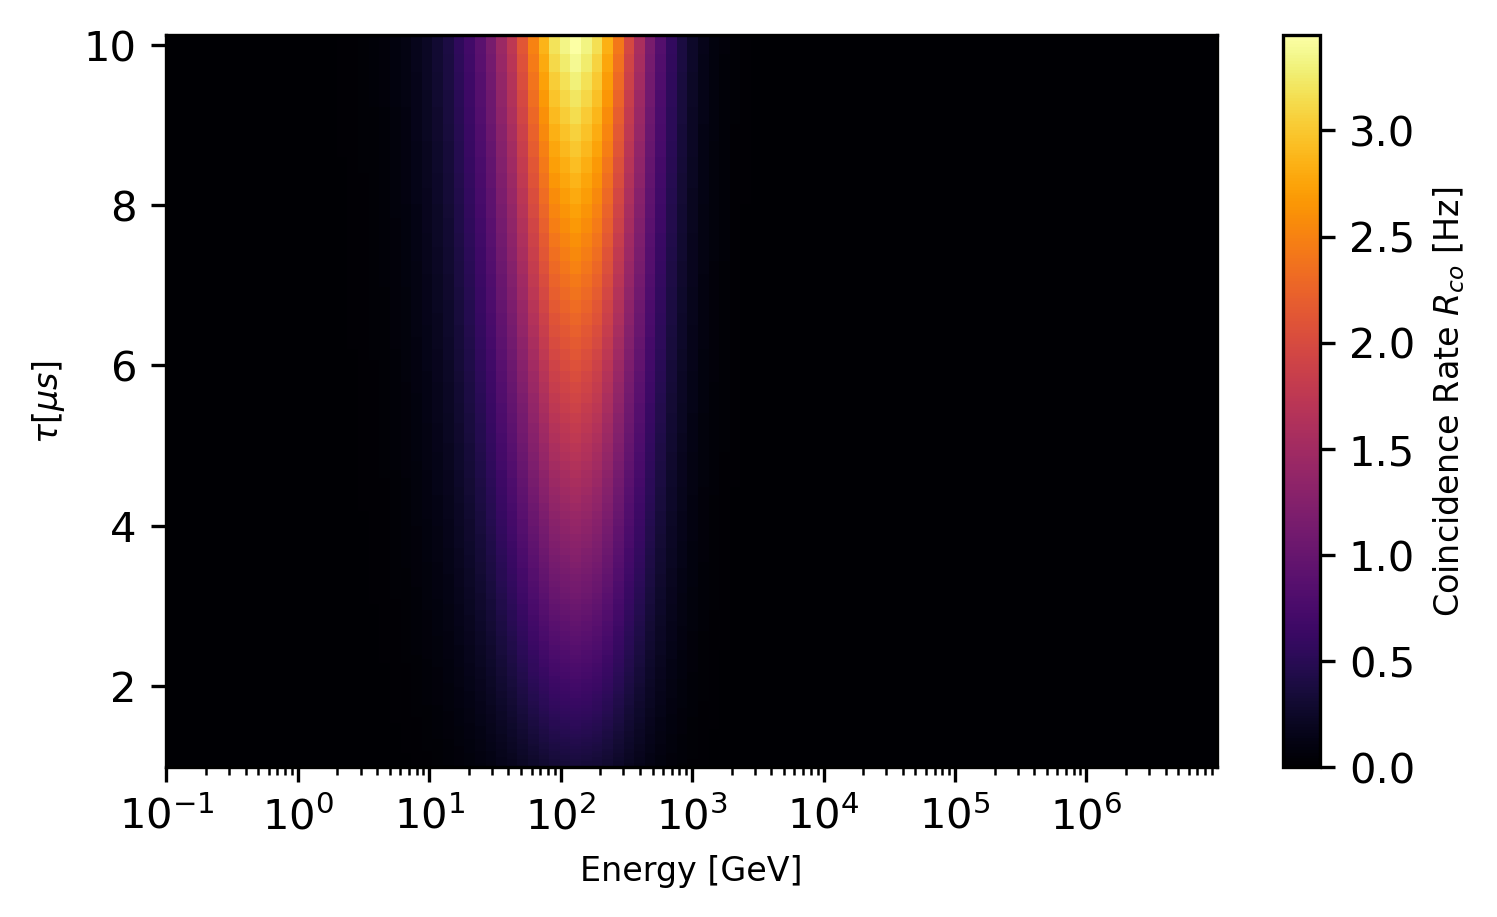

In [19]:
# Define the R_co function
# Define the R_co function
def R_co(R, tau):
    sum_k = sum(((R * tau) ** k) / factorial(k) for k in range(1, 100))
    result = R * np.exp(-R * tau) * sum_k
    return result

# Define tau values (in seconds)
tau_values = np.logspace(-6, -5, 100)  # Logarithmic tau values in seconds

# Convert tau values to microseconds
tau_values_microseconds = tau_values * 1e6  # Convert seconds to microseconds

# Create a 2D array to store R_co values
R_co_matrix = np.zeros((len(tau_values), len(bin_centers_1)))

# Compute R_co for each combination of energy bin and tau
for i, tau in enumerate(tau_values):
    for j, R in enumerate(counts_1):  # counts_1 represents the R values for energy bins
        R_co_matrix[i, j] = R_co(R, tau)

# Plot the heatmap
plt.figure(figsize=(5, 3), dpi=300)
plt.pcolormesh(bin_centers_1, tau_values_microseconds, R_co_matrix, shading='auto', cmap='inferno',
               norm=plt.Normalize(vmin=0, vmax=np.max(R_co_matrix)))

# Add color bar
cbar = plt.colorbar()
cbar.set_label(r'Coincidence Rate $R_{co}$ [Hz]', fontsize=8)

# Set axis scales and labels
plt.xscale('log')  # Logarithmic scale for energy
plt.yscale('linear')  # Linear scale for tau (in microseconds)

plt.xlabel('Energy [GeV]', fontsize=8)
plt.ylabel(r'$\tau [\mu s]$', fontsize=8)  # Update y-axis label to microseconds

plt.tight_layout(pad=0.5)
plt.savefig('heatmap_energy_microseconds.png', format='png')
plt.show()



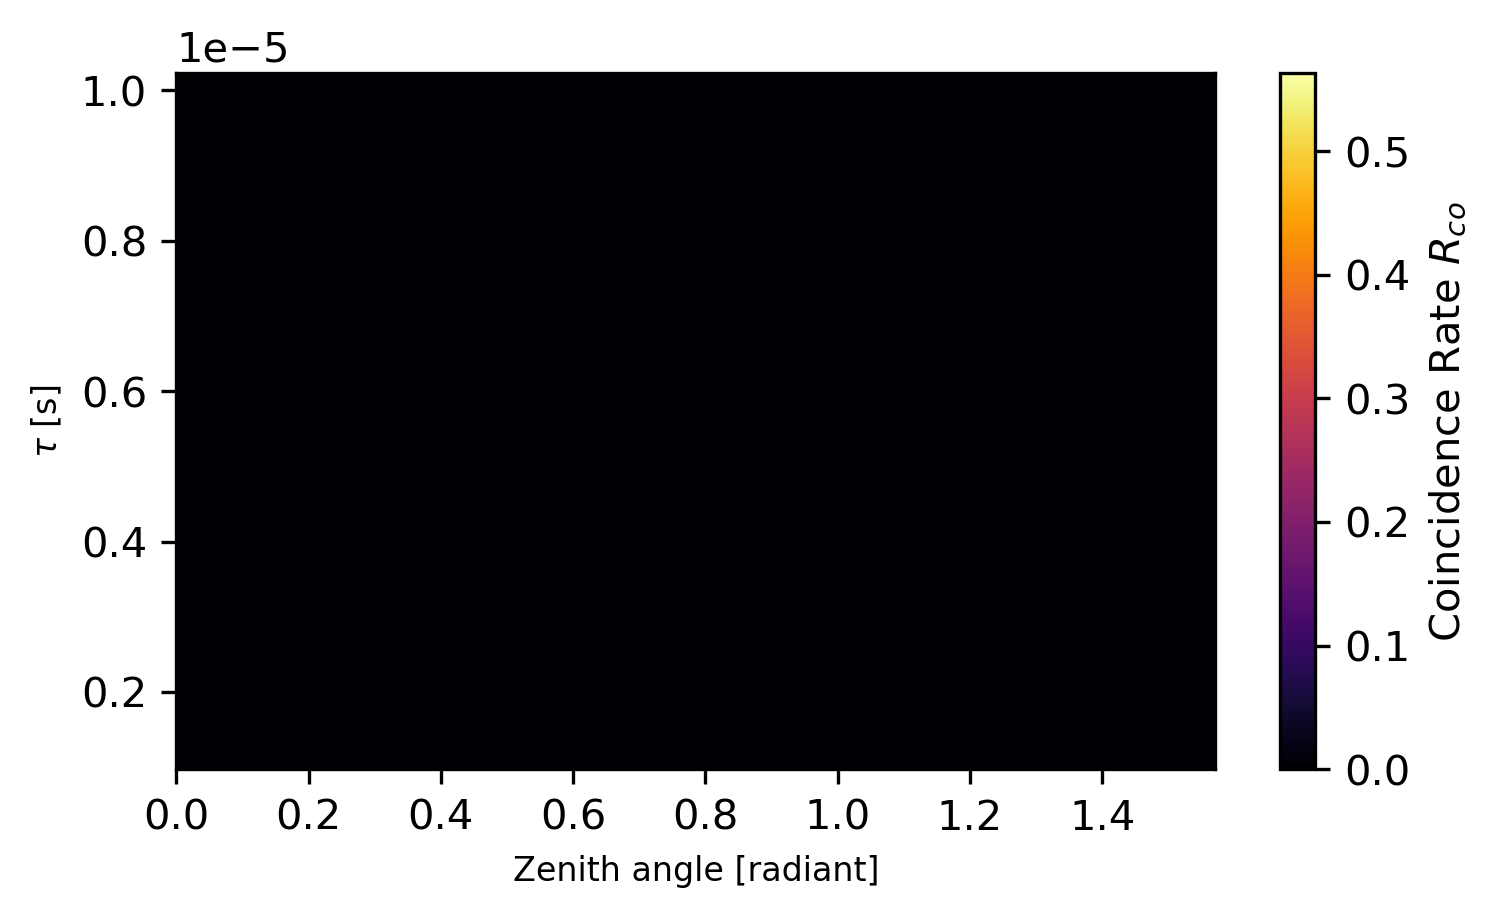

In [20]:
# Define the R_co function
def R_co(R, tau):
    sum_k = sum(((R * tau) ** k) / factorial(k) for k in range(1, 100))
    result = R * np.exp(-R * tau) * sum_k
    return result

# Define tau values
tau_values = np.logspace(-6, -5, 50)  # Logarithmic tau values

# Create a 2D array to store R_co values
R_co_matrix = np.zeros((len(tau_values), len(bin_centers_1)))

# Compute R_co for each combination of energy bin and tau
for i, tau in enumerate(tau_values):
    for j, R in enumerate(counts_zenith):  # counts_1 represents the R values for energy bins
        R_co_matrix[i, j] = R_co(R, tau)

# Plot the heatmap
plt.figure(figsize=(5, 3), dpi=300)
plt.pcolormesh(bin_centers_zenith, tau_values, R_co_matrix, shading='auto', cmap='inferno',
               norm=plt.Normalize(vmin=0, vmax=np.max(R_co_matrix)))

# Add color bar
cbar = plt.colorbar()
cbar.set_label(r'Coincidence Rate $R_{co}$', fontsize=10)

# Set axis scales and labels
plt.xlim(0,np.pi/2)
plt.xscale('linear')  # Logarithmic scale for energy
plt.yscale('linear')  # Linear scale for tau
plt.xlabel('Zenith angle [radiant]', fontsize=8)
plt.ylabel(r'$\tau$ [s]', fontsize=8)
#plt.title(r'Heatmap of $R_{co}$ as a Function of Zenith Angle  and $\tau$', fontsize=12)
plt.tight_layout(pad=0.5)
plt.savefig('heatmap_zenith.png', format='png')
plt.show()

In [21]:
# # Define the R_co function
# def R_co(R, tau):
#     sum_k = sum(((R * tau) ** k) / factorial(k) for k in range(1, 100))
#     result = np.exp(-R * tau) * sum_k
#     return result

# # Define tau values
# tau_values = np.logspace(-6, -5, 100)  # Logarithmic tau values

# # Create a 2D array to store R_co values
# R_co_matrix = np.zeros((len(tau_values), len(bin_centers_1)))

# # Compute R_co for each combination of energy bin and tau
# for i, tau in enumerate(tau_values):
#     for j, R in enumerate(counts_1):  # counts_1 represents the R values for energy bins
#         R_co_matrix[i, j] = R_co(R, tau)

# # Plot the heatmap
# plt.figure(figsize=(5, 3), dpi=300)
# plt.pcolormesh(bin_centers_1, tau_values, R_co_matrix, shading='auto', cmap='inferno',
#                norm=plt.Normalize(vmin=0, vmax=np.max(R_co_matrix)))

# # Add color bar
# cbar = plt.colorbar()
# cbar.set_label(r'Coincidence Rate $R_{co}$', fontsize=10)

# # Set axis scales and labels
# plt.xscale('log')  # Logarithmic scale for energy
# plt.yscale('linear')  # Linear scale for tau
# plt.xlabel('Energy [GeV]', fontsize=8)
# plt.ylabel(r'$\tau$ [s]', fontsize=8)
# #plt.title(r'Heatmap of $R_{co}$ as a Function of Energy and $\tau$', fontsize=12)
# plt.tight_layout(pad=0.5)
# plt.savefig('heatmap_energy.png', format='png')
# plt.show()


In [22]:
# # Debugging: Print some key values
# print("Counts_1 (first 10 values):", counts_1[:10])  # Print first 10 energy counts
# print("Bin Centers (first 10 values):", bin_centers_1[:10])  # Print first 10 bin centers
# print("Tau Values (all):", tau_values)  # Print all tau values

# # Debugging: Check R_co for specific values
# print("R_co Test (counts_1[0], tau_values[0]):", R_co(counts_1[0], tau_values[0]))

# # Debugging: Check R_co_matrix population
# print("R_co Matrix Shape:", R_co_matrix.shape)
# print("R_co Matrix (first 5 rows, first 5 columns):\n", R_co_matrix[:5, :5])  # Print top-left section of the matrix